# Tutorial 42: Higher L-Moments OWA Portfolio Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-19,0.0475%,-0.8599%,-1.4333%,-3.0011%,0.1113%,1.2968%,3.4360%,-0.8764%,0.2945%,-0.7834%,...,0.6339%,-0.1823%,0.9186%,-0.7728%,1.1385%,-1.6075%,-1.1144%,-1.2872%,0.4574%,-0.8026%
2018-10-22,-1.9240%,-0.0786%,-0.6334%,-6.2984%,-0.6393%,-1.1024%,0.0527%,-0.3221%,1.1325%,-0.8199%,...,-0.8661%,0.4483%,-1.6954%,-2.8972%,-0.6085%,1.4752%,-0.6075%,-0.8634%,0.1457%,-3.4490%
2018-10-23,-3.6570%,-1.6658%,-0.4202%,-0.4520%,-0.2797%,-0.5034%,0.1845%,-3.9948%,-0.7051%,-0.2449%,...,0.4766%,-5.1239%,0.5342%,-0.0321%,1.0713%,-0.6728%,-1.0808%,-1.8308%,4.0560%,4.0353%
2018-10-24,-4.5501%,1.3141%,-1.8041%,-3.5933%,-4.2917%,0.8674%,0.9995%,-4.1108%,-3.6759%,-3.7140%,...,3.5178%,-4.2683%,1.5636%,-1.3479%,-8.0557%,-0.4839%,-1.2403%,-4.2187%,0.3671%,-3.3065%
2018-10-25,0.4741%,2.5716%,0.5186%,0.7782%,5.0410%,-0.5733%,-1.1719%,2.1584%,3.1656%,2.3271%,...,-1.0310%,0.4914%,0.5082%,0.9109%,-1.2516%,1.8962%,4.3662%,1.3799%,-1.7241%,3.3538%


## 2. Estimating Higher L-Moments OWA Portfolios

### Higher L-Moments OWA Portfolios 설명

**Higher L-Moments OWA (Ordered Weighted Averaging) Portfolios**는 자산 수익률의 분포 특성을 반영하기 위해 고차 L-모멘트를 사용하는 포트폴리오 최적화 방법입니다. L-모멘트는 데이터 분포의 다양한 특성을 포착하는 데 사용되며, 특히 비대칭성 및 극단치에 대한 민감도를 조정할 수 있습니다. OWA는 다양한 리스크 측정치와 목표 함수를 사용하여 포트폴리오를 최적화할 수 있는 유연한 방법론을 제공합니다.

### L-Moments란?

L-모멘트는 전통적인 모멘트(예: 평균, 분산)와 유사하지만, 더 견고하고 효율적인 분포 특성 추정치를 제공합니다. L-모멘트는 특히 데이터의 비대칭성과 꼬리 부분을 잘 반영하는 특성을 가지고 있습니다.

### 고차 L-모멘트 사용

고차 L-모멘트를 사용하면 포트폴리오 최적화에서 다음과 같은 이점을 얻을 수 있습니다:
- **비대칭성 반영**: 분포의 비대칭성을 더 잘 반영하여 리스크 평가를 개선합니다.
- **극단치 관리**: 꼬리 리스크를 더 효과적으로 관리할 수 있습니다.

### OWA 포트폴리오 최적화와 L-모멘트 결합

OWA 포트폴리오 최적화는 다양한 순서 통계량을 사용하여 가중치를 부여하는 방식으로, 고차 L-모멘트를 포함한 다양한 리스크 측정치를 통합할 수 있습니다. 이를 통해 포트폴리오의 리스크와 수익률 특성을 더 잘 반영할 수 있습니다.

### 예제 코드

아래는 `Riskfolio-Lib`를 사용하여 고차 L-모멘트를 포함한 OWA 포트폴리오를 최적화하는 예제 코드입니다:

```python
import numpy as np
import pandas as pd
import riskfolio as rp
import matplotlib.pyplot as plt

# 예시 데이터 생성
np.random.seed(42)
Y = np.random.randn(100, 10)  # 100개의 샘플과 10개의 자산
asset_names = [f'Asset {i}' for i in range(1, 11)]
returns = pd.DataFrame(Y, columns=asset_names)

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=returns)

# 기대 수익률, 공분산 행렬 및 고차 L-모멘트 추정
method_mu = 'hist'
method_cov = 'hist'
method_lmom = 'hist'  # 역사적 데이터를 사용하여 고차 L-모멘트 추정
port.assets_stats(method_mu=method_mu, method_cov=method_cov, method_lmom=method_lmom)

# 최적화 매개변수 설정
model = 'Classic'  # 사용할 모델: Classic (historical), BL (Black Litterman), FM (Factor Model)
rm = 'L4'  # 리스크 측정치로 4차 L-모멘트 사용
obj = 'Sharpe'  # 목표 함수: Sharpe 비율 최대화
hist = True  # 역사적 시나리오 사용 여부
rf = 0  # 무위험 이자율
l = 0  # 리스크 회피 계수 (유틸리티 목표 함수에서만 사용)

# 최적 포트폴리오 계산
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# 히스토그램 플롯
ax = rp.plot_hist(returns=Y, w=w, alpha=0.05, bins=50, height=6, width=10, ax=None)

# 플롯 표시
plt.show()
```

### 코드 설명

1. **데이터 준비 및 포트폴리오 객체 생성**:
   ```python
   np.random.seed(42)
   Y = np.random.randn(100, 10)
   asset_names = [f'Asset {i}' for i in range(1, 11)]
   returns = pd.DataFrame(Y, columns=asset_names)
   port = rp.Portfolio(returns=returns)
   ```

   - 예시 데이터를 생성하고 자산 이름을 설정합니다.
   - `rp.Portfolio` 클래스를 사용하여 포트폴리오 객체를 생성합니다.

2. **기대 수익률, 공분산 행렬 및 고차 L-모멘트 추정**:
   ```python
   method_mu = 'hist'
   method_cov = 'hist'
   method_lmom = 'hist'
   port.assets_stats(method_mu=method_mu, method_cov=method_cov, method_lmom=method_lmom)
   ```

   - 역사적 데이터를 기반으로 기대 수익률, 공분산 행렬 및 고차 L-모멘트를 추정합니다.

3. **최적화 매개변수 설정**:
   ```python
   model = 'Classic'
   rm = 'L4'
   obj = 'Sharpe'
   hist = True
   rf = 0
   l = 0
   ```

   - 클래식 모델을 사용하고, 4차 L-모멘트를 리스크 측정치로 설정하며, 목표 함수를 Sharpe 비율 최대화로 설정합니다.
   - 역사적 시나리오를 사용하며, 무위험 이자율은 0으로 설정합니다.

4. **최적 포트폴리오 계산**:
   ```python
   w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
   ```

   - 지정된 매개변수에 따라 포트폴리오를 최적화합니다.

5. **히스토그램 플롯 및 표시**:
   ```python
   ax = rp.plot_hist(returns=Y, w=w, alpha=0.05, bins=50, height=6, width=10, ax=None)
   plt.show()
   ```

   - `plot_hist` 함수를 사용하여 히스토그램을 플롯하고, 최적화된 포트폴리오의 수익률 분포를 시각화합니다.

### 결론

Higher L-Moments OWA 포트폴리오 모델은 고차 L-모멘트를 사용하여 자산 수익률의 비대칭성과 극단치를 더 잘 반영하는 포트폴리오 최적화를 제공합니다. 이 모델은 다양한 리스크 측정치와 목표 함수를 통합할 수 있는 유연한 접근법을 통해 투자자의 리스크 관리와 수익률 최적화를 도와줍니다. 위 예제 코드는 Higher L-Moments OWA 포트폴리오를 최적화하는 방법을 보여주며, 다양한 투자 전략을 검토하고 실행하는 데 도움이 됩니다.

Cajas(2021)이 제안한 OWA 포트폴리오 모델은 OWA 연산자를 사용하여 표현할 수 있는 리스크 측정치에 대한 대체 공식을 제공합니다. Higher L-Moments 포트폴리오는 Cajas(2023)을 따르는 가중치에 따라 결정되는 OWA 포트폴리오의 특수한 사례입니다.

OWA 포트폴리오는 모델이 사용하는 제약 조건과 변수의 수 때문에 더 많은 계산 능력이 필요하므로 MOSEK를 사용하여 최적화하는 것이 권장됩니다.

MOSEK 설치 지침은 이 링크에서 확인할 수 있으며, Anaconda를 사용하는 것이 좋습니다. 또한, 학술용 라이선스를 요청하는 것을 권장합니다.

- [MOSEK 설치 지침](https://www.mosek.com/products/academic-licenses/)

### 2.1 Calculating the portfolio that minimize a risk measure that includes Higher L-Moments

In [3]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

# Estimate optimal portfolios:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

owa_w = rp.owa_l_moment_crm(len(Y), k=4)

w = port.owa_optimization(obj=obj,
                          owa_w=owa_w,
                          rf=rf,
                          l=l)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,3.8296%,0.0000%,3.1847%,4.6133%,9.2607%,2.7655%,0.0000%,0.0000%,7.1173%,...,13.2586%,0.0003%,19.9776%,3.7651%,3.3470%,0.0000%,0.0000%,0.0000%,15.6934%,0.0000%


이 코드는 `Riskfolio-Lib` 라이브러리를 사용하여 OWA(Ordered Weighted Averaging) 포트폴리오를 최적화하는 예제입니다. MOSEK 솔버를 사용하여 최적화를 수행하며, 기대 수익률 및 공분산 행렬을 역사적 데이터를 기반으로 추정합니다. 각 단계별로 코드를 설명하겠습니다.

### 코드 설명

1. **필요한 라이브러리 임포트**:
   ```python
   import riskfolio as rp
   import mosek
   ```

   - `riskfolio` 및 `mosek` 라이브러리를 임포트합니다.

2. **포트폴리오 객체 생성**:
   ```python
   port = rp.Portfolio(returns=Y)
   ```

   - `rp.Portfolio` 클래스를 사용하여 포트폴리오 객체를 생성합니다.
   - `returns=Y`: 자산의 역사적 수익률 데이터 `Y`를 사용합니다.

3. **기대 수익률 및 공분산 행렬 추정**:
   ```python
   method_mu='hist'  # 역사적 데이터를 사용하여 기대 수익률 추정
   method_cov='hist'  # 역사적 데이터를 사용하여 공분산 행렬 추정

   port.assets_stats(method_mu=method_mu, method_cov=method_cov)
   ```

   - `method_mu='hist'`: 역사적 데이터를 기반으로 기대 수익률을 추정합니다.
   - `method_cov='hist'`: 역사적 데이터를 기반으로 공분산 행렬을 추정합니다.
   - `port.assets_stats` 함수는 지정된 방법에 따라 자산의 통계를 계산합니다.

4. **MOSEK 솔버 설정**:
   ```python
   port.solvers = ['MOSEK']  # OWA 포트폴리오 최적화를 위해 MOSEK 솔버 사용
   port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}
   ```

   - `port.solvers = ['MOSEK']`: MOSEK 솔버를 사용하여 최적화를 수행하도록 설정합니다.
   - `port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}`: MOSEK 솔버 매개변수를 설정하여 최적화에 사용할 스레드 수를 2로 설정합니다.

5. **목표 함수 및 기타 매개변수 설정**:
   ```python
   obj = 'MinRisk'  # 목표 함수: 리스크 최소화 (MinRisk), 최대 수익률 (MaxRet), 유틸리티 최대화 (Utility) 또는 Sharpe 비율 최대화 (Sharpe) 중 하나
   rf = 0  # 무위험 이자율
   l = 0  # 리스크 회피 계수, 유틸리티 목표 함수에서만 사용
   ```

   - `obj = 'MinRisk'`: 리스크 최소화를 목표로 설정합니다.
   - `rf = 0`: 무위험 이자율을 0으로 설정합니다.
   - `l = 0`: 리스크 회피 계수를 0으로 설정합니다.

6. **OWA 가중치 계산**:
   ```python
   owa_w = rp.owa_l_moment_crm(len(Y), k=4)
   ```

   - `rp.owa_l_moment_crm` 함수를 사용하여 OWA 가중치를 계산합니다.
   - `len(Y)`: 데이터 샘플의 길이를 입력으로 사용합니다.
   - `k=4`: 4차 L-모멘트를 사용합니다.

7. **OWA 포트폴리오 최적화**:
   ```python
   w = port.owa_optimization(obj=obj, owa_w=owa_w, rf=rf, l=l)
   ```

   - `port.owa_optimization` 함수를 사용하여 지정된 매개변수에 따라 OWA 포트폴리오를 최적화합니다.
   - `obj`: 목표 함수 설정.
   - `owa_w`: OWA 가중치 벡터.
   - `rf`: 무위험 이자율.
   - `l`: 리스크 회피 계수.

8. **결과 출력**:
   ```python
   display(w.T)
   ```

   - `display(w.T)` 함수를 사용하여 최적화된 포트폴리오 가중치를 전치하여 보기 좋게 출력합니다.

### 전체 코드

```python
import riskfolio as rp
import mosek

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=Y)

# 기대 수익률 및 공분산 행렬 추정
method_mu = 'hist'  # 역사적 데이터를 사용하여 기대 수익률 추정
method_cov = 'hist'  # 역사적 데이터를 사용하여 공분산 행렬 추정
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# MOSEK 솔버 설정
port.solvers = ['MOSEK']
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

# 목표 함수 및 기타 매개변수 설정
obj = 'MinRisk'
rf = 0
l = 0

# OWA 가중치 계산
owa_w = rp.owa_l_moment_crm(len(Y), k=4)

# OWA 포트폴리오 최적화
w = port.owa_optimization(obj=obj, owa_w=owa_w, rf=rf, l=l)

# 결과 출력
display(w.T)
```

이 코드는 OWA 포트폴리오를 최적화하여 리스크를 최소화하는 방법을 보여줍니다. MOSEK 솔버를 사용하여 높은 계산 성능을 확보하고, 역사적 데이터를 기반으로 자산의 기대 수익률 및 공분산 행렬을 추정합니다. OWA 가중치를 계산하고 이를 사용하여 포트폴리오를 최적화하여 최적의 투자 전략을 확인할 수 있습니다.

### 2.2 Plotting portfolio composition

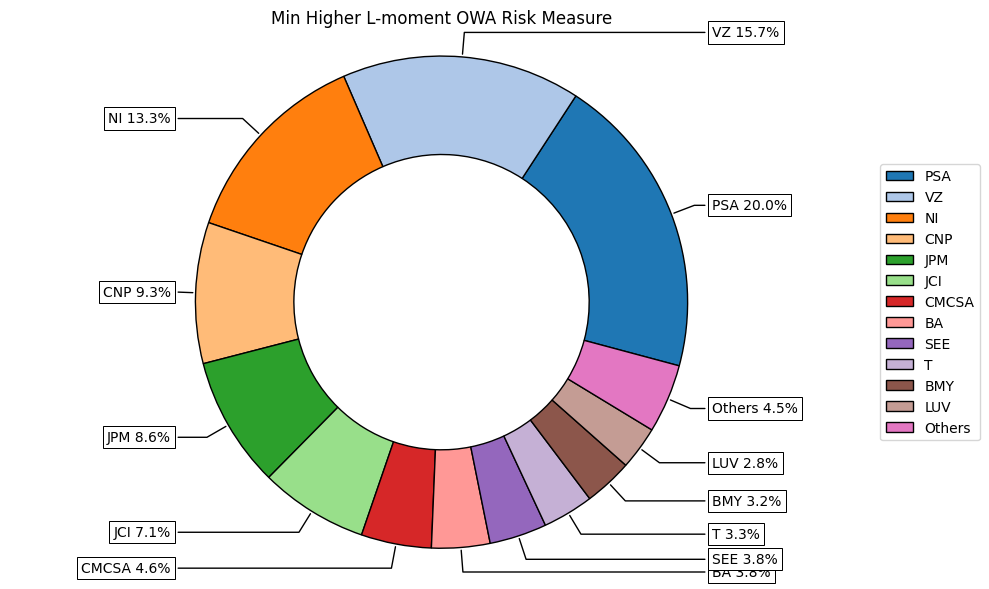

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Min Higher L-moment OWA Risk Measure',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)